# Notebook to Retrieve and Inspect DSVM Files 

# Step 0 - Set up Notebook

In [55]:
import pandas 
import geopandas as gpd
import numpy as np
import rasterio
import boto3
import json
import tempfile
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.geometry import box
from shapely.ops import unary_union
from rasterio.plot import show
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd
from snowML.viz import vis_utils as vu

# Step 1 - Define Some Functions for Dealing with Raster Data 

In [2]:
def inspect(raster_path): 
    with rasterio.open(raster_path) as src:
        band_count = src.count
        print(f"The raster has {band_count} band(s).")
        data = src.read(1)  # Read the first (and likely only) band
        nodata = src.nodata
        profile = src.profile
        bounds = src.bounds
        crs = src.crs
        
        print("CRS:", crs)
        print("Bounds:", bounds)
        print("Data shape:", data.shape) 
        print("Profile:", profile)
        show(src)

    # Get unique values
    unique_values = np.unique(data)

    print("Unique values in the raster:")
    print(unique_values)


In [3]:
def load_raster(raster_path, band = 1): 
    with rasterio.open(raster_path) as src:
        band_count = src.count
        print(f"The raster has {band_count} band(s).")
        data = src.read(1)  # Read the first (and likely only) band
    
    

In [4]:
# Assume source crs is EPSG 26910 (traditional choice for Western WA) if none specified in metadata 

def convert_to_gdp(raster_path, source_crs = "EPSG:26910"): 
    
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform

        # Create a mask for included areas (value == 1)
        mask = data == 1

        # Extract shapes (polygons) from raster mask
        results = (
            {'geometry': shape(geom), 'value': value}
            for geom, value in shapes(data, mask=mask, transform=transform)
        )

        # Convert to GeoDataFrame
        gdf = gpd.GeoDataFrame.from_records(results)

        # Drop the 'value' column if only geometry is needed
        gdf = gdf.drop(columns='value')
        gdf = gdf.set_geometry("geometry")

        # Assign the source CRS and reproject to EPSG:4326
        gdf.set_crs(source_crs, inplace=True)
        gdf = gdf.to_crs("EPSG:4326")

    return gdf


In [46]:
def save_gdf_to_s3_geojson(gdf, f_out):
    """
    Save a GeoDataFrame as a GeoJSON file to the 'snowml-shape' S3 bucket.

    Parameters:
        gdf (GeoDataFrame): The GeoDataFrame to save.
        f_out (str): Desired S3 key (filename), e.g., 'cedar_geometry.geojson'
    """
    # Save locally to a temp file
    with tempfile.NamedTemporaryFile(suffix=".geojson") as tmpfile:
        gdf.to_file(tmpfile.name, driver="GeoJSON")

        # Upload to S3
        s3 = boto3.client("s3")
        s3.upload_file(tmpfile.name, "snowml-shape", f_out)


# Step 2  - Define Raster Paths 

In [5]:
rp_cedar =  "https://data.cig.uw.edu/picea/mauger/misc/wrf_run_agg/cedar_mask/"
rp_snoho  = "https://data.cig.uw.edu/picea/mauger/misc/wrf_run_agg/snoho_mask/"
rp_green = "https://data.cig.uw.edu/picea/mauger/misc/wrf_run_agg/green_mask/"

# Step 3 - Inspect Example

The raster has 1 band(s).
CRS: None
Bounds: BoundingBox(left=556472.33842883, bottom=5231786.4732985, right=619622.33842883, top=5263136.4732985)
Data shape: (209, 421)
Profile: {'driver': 'AIG', 'dtype': 'uint8', 'nodata': 255.0, 'width': 421, 'height': 209, 'count': 1, 'crs': None, 'transform': Affine(150.0, 0.0, 556472.33842883,
       0.0, -150.0, 5263136.4732985), 'blockxsize': 256, 'blockysize': 16, 'tiled': True}


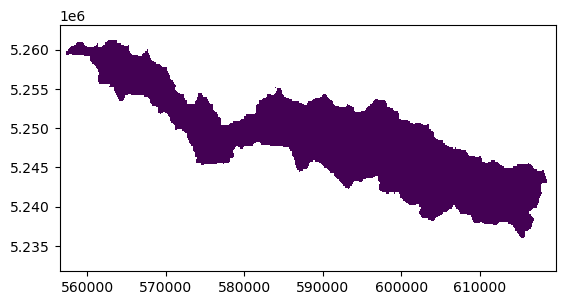

Unique values in the raster:
[  1 255]


In [7]:
inspect(rp_cedar)

In [8]:
geos_cedar = convert_to_gdp(rp_cedar)

In [9]:
geos_cedar.explore()

# Step 4 - Create DEM and Snow Type Maps 


In [64]:
dem_ds = gd.get_dem(geos_cedar)
f_out = "../../docs/basic_maps/Digital_Elevation_Model_(DEM)_for_Cedar_HSVM"
vu.plot_dem(dem_ds, geos_cedar, "Cedar", f_out = f_out) 

Map saved to ../../docs/basic_maps/Digital_Elevation_Model_(DEM)_for_Cedar_HSVM


In [67]:
ds_snow = st.get_snow_class_data(geos_cedar)
vu.map_snow_types(ds_snow, geos_cedar, "Cedar", huc_lev = '10', output_dir = "../../docs/bacis_maps")

Map saved to ../../docs/bacis_maps/Snow_classes_for_huc10in_Cedar.png


# Step 5 - Get SubBasins

In [10]:
# define a function that calculates percent overlap between the geometries in two gdfs 
def percent_overlap(geom1, geom2, geom1_name, geom2_name):
  
    # Reproject
    geom1 = geom1.to_crs("EPSG:26910")
    geom2 = geom2.to_crs("EPSG:26910")
    
    # Calculate intersection area
    intersection = geom1.intersection(geom2)
    intersection_area = intersection.area
    
    # Calculate percentages
    percent_1_in_2 = (intersection_area / geom1.area) * 100
    percent_2_in_1 = (intersection_area / geom2.area) * 100

    print(f"percent_{geom1_name}_in_{geom2_name} is {round(percent_1_in_2.iloc[0])}")
    print(f"percent_{geom2_name}_in_{geom1_name} is {round(percent_2_in_1.iloc[0])}")
    
  


In [11]:
def visual_inspect(gdf1, gdf2, gdf1_name, gdf2_name): 
   # Start the map with the first GeoDataFrame
    m = gdf1.explore(color="blue", style_kwds={'fillOpacity': 0.3}, name=gdf1_name)

    # Add the second GeoDataFrame to the same map
    gdf2.explore(m=m, color="red", style_kwds={'fillOpacity': 0.3}, name=gdf2_name)

    return m


In [12]:
# look at huc 10s in lake Washington basin
geos_lake_wash = gg.get_geos_with_name(17110012, '10')
geos_lake_wash.explore()

In [13]:
# guess huc 
huc10_cedar = "1711001201"
geos_cedar_10 = gg.get_geos_with_name(huc10_cedar, '10')
geos_cedar_12 = gg.get_geos_with_name(huc10_cedar, '12')

In [14]:
# visual inspect
visual_inspect(geos_cedar, geos_cedar_12, "hsvm_shape", "huc_12_boundaries")

In [15]:
# caclulate overlap 
percent_overlap(geos_cedar.geometry, geos_cedar_10.geometry, "hsvm_shape", "huc_boundaries")

percent_hsvm_shape_in_huc_boundaries is 97
percent_huc_boundaries_in_hsvm_shape is 90


From visual inspection, rough correspondence btw hsvm and huc boundaries except hsvm seems to exclude rock creek, 1711000120106
How do things look if we filter that out 

In [38]:
hucs_in_cedar = geos_cedar_12[geos_cedar_12["huc_id"] != "171100120106"]
#hucs_in_cedar
combined_geometry = hucs_in_cedar.geometry.union_all()
# Wrap it in a GeoDataFrame so it supports to_crs()
combined_gdf = gpd.GeoDataFrame(geometry=[combined_geometry], crs=hucs_in_cedar.crs)

In [39]:
# visual inspect
visual_inspect(geos_cedar, hucs_in_cedar, "hsvm_shape", "huc_12_boundaries")

In [40]:
# caclulate overlap 
percent_overlap(geos_cedar.geometry, combined_gdf.geometry, "hsvm_shape", "huc_boundaries")

percent_hsvm_shape_in_huc_boundaries is 95
percent_huc_boundaries_in_hsvm_shape is 96


In [50]:
# Save cedar files
save_gdf_to_s3_geojson(geos_cedar, "hsvm_cedar.geojson")
save_gdf_to_s3_geojson(hucs_in_cedar, "hucs_match_hsvm_cedar.geojson")

# Step 5 - Get Snow Type Info 

In [42]:
df_snow_types, snow_class_counts, df_predom = st.process_all(huc10_cedar, '12')

In [17]:
df_snow_types

,huc_id,Tundra,Boreal Forest,Maritime,Ephemeral,Prairie,Montane Forest,Ice,Ocean
0,171100120101,0.0,0.0,75.0,25.0,0.0,0.0,0.0,0.0
1,171100120102,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0
2,171100120103,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0
3,171100120104,0.0,0.0,33.0,67.0,0.0,0.0,0.0,0.0
4,171100120105,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
5,171100120106,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,171100120107,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
7,Average,0.0,0.0,29.7,70.3,0.0,0.0,0.0,0.0


# Step Last - Repeat for Additional Raster Paths (Green)

In [18]:
#inspect(rp_green)

In [19]:
geos_green  = convert_to_gdp(rp_green)

In [20]:
geos_green.explore()

In [21]:
# guess huc 
huc8_green = "17110013"
geos_green_08 = gg.get_geos_with_name(huc8_green, '08')
geos_green_10 = gg.get_geos_with_name(huc8_green, '10')
geos_green_12 = gg.get_geos_with_name(huc8_green, '12')


In [22]:
# visual inspect
visual_inspect(geos_green, geos_green_12, "hsvm_shape", "huc_12_boundaries")

In [23]:
# caclulate overlap 
percent_overlap(geos_green.geometry, geos_green_08.geometry, "hsvm_shape", "huc_boundaries")

percent_hsvm_shape_in_huc_boundaries is 96
percent_huc_boundaries_in_hsvm_shape is 95


In [25]:
df_snow_types, snow_class_counts, df_predom = st.process_all(huc8_green, '12')

In [26]:
df_snow_types

,huc_id,Tundra,Boreal Forest,Maritime,Ephemeral,Prairie,Montane Forest,Ice,Ocean
0,171100130101,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
1,171100130102,0.0,0.0,67.0,33.0,0.0,0.0,0.0,0.0
2,171100130103,0.0,0.0,80.0,20.0,0.0,0.0,0.0,0.0
3,171100130104,0.0,0.0,83.0,17.0,0.0,0.0,0.0,0.0
4,171100130105,0.0,0.0,75.0,25.0,0.0,0.0,0.0,0.0
5,171100130106,0.0,0.0,33.0,67.0,0.0,0.0,0.0,0.0
6,171100130201,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
7,171100130202,0.0,0.0,33.0,67.0,0.0,0.0,0.0,0.0
8,171100130203,0.0,0.0,40.0,60.0,0.0,0.0,0.0,0.0
9,171100130204,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


# Step Last - Repeat for Additional Raster Paths (Snohomish)

In [ ]:
#inspect(rp_snoho)

In [ ]:
geos_snoho = convert_to_gdp(rp_snoho)

In [ ]:
geos_snoho.explore()

In [ ]:
# look at huc 10s in lake Sammish Basin 
geos_lake_samm = gg.get_geos_with_name(17110011, '10')
geos_lake_samm.explore()

In [ ]:
# guess huc 
huc10_snoho = "17110011"
geos_snoho_10 = gg.get_geos_with_name(huc10_snoho, '10')
geos_snoho_12 = gg.get_geos_with_name(huc10_snoho, '12')

In [ ]:
# visual inspect
visual_inspect(geos_snoho, geos_snoho_12, "hsvm_shape", "huc_12_boundaries")